**<h1><center>Lid-driven cavity flow </center></h1>**

**Rédacteurs :** JUNNE Jonathan (000441146) et MOL Louan (000440167).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

On s'intéresse au problème du lid-driven cavity flow déduit des équations de Navier-Stokes proposé par le MOOC numérique : https://github.com/bknaepen/MATHF314/blob/master/Stokes/05_05_Stokes.Flow.Bihar.ipynb

Ce problème peut se réduire à une équation bi-harmonique
\begin{equation}
    \nabla^4 \psi = 0
\end{equation}
d'une fonction de courant $\psi$ dans une boite bidimensionnelle $[0, L_x] \times [0, L_y]$ munie des conditions de Dirichlet et Von Neumann aux bords suivantes :
\begin{cases}
    \psi(0,y) = \psi\left(L_x, y\right) = \psi(x, 0) = \psi\left(x, L_y\right) = 0, \\
    \partial_x \psi(0, y) = \partial_x \psi\left(L_x, y\right) = \partial_y \psi(x,0) = 0, \\
    \partial_y \psi\left(L_y, x\right) = 1.
\end{cases}

On peut justifier ces paramètres aux bords. La fonction de courant aux bords est nulle car les particules sont liées à la paroi alors que la dérivée par rapport à $y$ est 1 car l'on tire le couvercle de manière uniforme et donc induit une variation de courant dans cette direction de 1.

Les paramètres de discrétisation sont imposés ainsi qu'une condition d'arrêt sur les itérations. On crée un meshgrid de notre domaine en $n_x \times n_y$ cellules de taille $\Delta x \times \Delta y$. On prend $n_x = n_y = 41, N = 40, l = h = 1, \Delta x = 1/\left(n_x - 1\right), \Delta y = 1/\left(n_y - 1\right)$ et l'on arrête l'itération lorsque $\left|\psi^{k} - \psi^{k-1}\right|_{L1} < 10^{-8}$ où $\psi^k$ est la fonction de courant de la k-ème itération des gradient conjugués.

In [2]:
nx = 41
ny = 41

l = 1. 
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

def l1_norm(new, old):
    norm = np.sum(np.abs(new-old))
    return norm

l1_target = 1e-8

Ainsi notre meshgrid impose $\Delta x = \Delta y = \Delta$.
On dispose de la méthode des différences finies pour approximer nos opérateurs différentiels. 
Dans ce notebook, on utilise la méthode des gradients conjugués pour résoudre numériquement ce problème en approximant les opérateurs différentiels via la méthode des différence finies centrées d'ordre deux. On note que $\nabla^4 \psi = \frac{\partial^4\psi}{\partial x^4} + \frac{\partial^4\psi}{\partial^4 y} + 2\frac{\partial^4 \psi}{\partial^2 y\partial^2 x}$. Ainsi de manière discrète à l'ordre 2,
\begin{align}
    \frac{\partial^4\psi}{\partial x^4} &= \frac{\psi_{i, j-2} - 4\psi_{i, j-1} + 6\psi_{i, j+1} - 4\psi_{i, j+1} + \psi_{i, j+2}}{\Delta^4}, \\
    \frac{\partial^4\psi}{\partial y^4} &= \frac{\psi_{i-2, j} - 4\psi_{i-1, j} + 6\psi_{i, j} - 4\psi_{i+1, j} + \psi_{i+2, j}}{\Delta^4}, \\
    \frac{\partial^4\psi}{\partial y^2\partial x^2} &= \frac{\partial^2 \psi}{\partial y^2}\left(\frac{\psi_{i, j-1} - 2\psi_{i,j} + \psi_{i, j+1}}{\Delta ^2}\right) \\
    &= \frac{\left(\psi_{i-1, j-1} - 2\psi_{i, j-1} + \psi_{i+1, j-1}\right) - 2\left(\psi_{i-1, j} - 2\psi_{i, j} + \psi_{i+1, j}\right) + \left(\psi_{i-1, j+1} - 2\psi_{i, j+1} + \psi_{i+1, j+1}\right)}{\Delta^4}.
\end{align}

On obtient alors la discrétisation suivante de l'équation bi-harmonique :
\begin{align}
     &\,\,\,\,\,\, \psi_{i-2, j}^k \\
     &+ 2\psi_{i-1, j-1}^k - 8\psi_{i-1, j}^k + 2\psi_{i-1, j+1}^k \\
     &+ \psi_{i, j-2}^k - 8\psi_{i, j-1}^k + 20\psi_{i, j}^k - 8\psi_{i, j+1}^k + \psi_{i, j+2}^k \\
     &+ 2\psi_{i+1, j-1}^k - 8\psi_{i+1, j}^k + 2\psi_{i+1, j+1}^k \\
     &+ \psi_{i+2, j}^k = 0.
\end{align}

Il s'agit d'une transformation linéaire sur $\psi^k$ à laquelle correspond un opérateur $A$ linéaire un terme de source $b$ tel que $A\psi^k = b$.
A celà vient s'ajouter les conditions de Von Neumann aux bords. On discrétise les opérateurs différentiels via les méthodes forward et backward respectivement ;
\begin{cases}
    -3\psi_{0, j}^k + 4\psi_{1, j}^k - \psi_{2, j}^k = 0, \\
    -3\psi_{i, 0}^k + 4\psi_{i, 1}^k - \psi_{i, 2}^k = 0, \\
    3\psi_{i, nx}^k - 4\psi_{i, nx-1}^k + \psi_{i, nx-2}^k = 0, \\
    3\psi_{ny, j}^k - 4\psi_{ny-1, j}^k + \psi_{ny-2, j}^k = 2\Delta.
\end{cases}

Enfin, les conditions de Dirichlet imposent $\psi_{0, j}^k = \psi_{nx, j}^k = \psi_{i, 0}^k = \psi_{i, ny}^k = 0$, et l'on obtient les contraintes suivantes :
\begin{cases}
    4\psi_{i, 1}^k - \psi_{i, 2}^k = 0, \\
    4\psi_{1, j}^k - \psi_{2, j}^k = 0, \\
    - 4\psi_{ny-1, j}^k + \psi_{ny-2, j}^k = 2\Delta, \\
    - 4\psi_{i, nx-1}^k + \psi_{i, nx-2}^k = 0.    
\end{cases}

Il est très important de noter que le problème discrétisé donnant $A\psi^k = b$ n'est défini à proprement parlé que sur les indices $[2, N-2] \times [2, N-2]$.
Ainsi, il faut au préalable appliquer les conditions précédentes sur $\psi^k$ afin de pouvoir calculer $A\psi^k$.
Les $\psi^k$ dont les indices appartiennet à $\{0, 1, N-2, N-1\} \times \{0, 1, N-2, N-1\}$ doivent donc être remplacés par des $\psi^k$ indicés dans $[2, N-2] \times [2, N-2]$ et ce en appliquant les équations précédentes.

Le terme en $2\Delta$ crée alors un terme de source $b$. Il est important de remarquer que le système n'est pas cohérant car appliquer les deux dernières équations dans un ordre différent change le terme de source. Afin d'obtenir un terme de source cohérent au problème analogue à une dimension, on applique l'ordre proposé par le système écrit ci-dessus donc $- 4\psi_{ny-1, j}^k + \psi_{ny-2, j}^k = 2\Delta$ puis $- 4\psi_{i, nx-1}^k + \psi_{i, nx-2}^k = 0$ en particulier.
Afin de calculer le terme de source, on peut noter que seuls les indices $i, j$ de $\left(\nabla^4 \psi^k\right)_{i,j}$ dans $\{N-3, N-2\} \times \{2, N_2\}$ font intervenir l'équation $- 4\psi_{ny-1, j}^k + \psi_{ny-2, j}^k = 2\Delta$. En dehors de ces indices, le terme de source correspondant $b$ est alors nul.

Pour les équation suivantes, on indique tous les indices faisant intevenir le terme en $2\Delta$ pour un indice $i, j$ de $\left(\nabla^4 \psi^k\right)_{i,j}.$

Pour $\left(\nabla^4 \psi^k\right)_{N-3, 2:N-2}$ :
\begin{equation}
    \psi_{N-1, 2:N-2}^k = 1/4\psi_{N-2, 2:N-2}^k - \Delta/2.
\end{equation}

Pour $\left(\nabla^4 \psi^k\right)_{N-2, 2}$ : 
\begin{cases}
    2\psi_{N-1, 1}^k &= 1/8 \psi_{N-2, 2}^k - \Delta, \\
    -8\psi_{N-1, 2}^k &= -2\psi_{N-2, 2}^k + 4\Delta, \\
    2\psi_{N-1, 3}^k &= 1/2\psi_{N-2, 3}^k - \Delta.
\end{cases}

Pour $\left(\nabla^4 \psi^k\right)_{N-2, 3:N-3}$ :
\begin{cases}
    2\psi_{N-1, 2:N-4}^k &= 1/2\psi_{N-2, 2:N-4}^k - \Delta, \\
    -8\psi_{N-1, 3:N-3}^k &= -2\psi_{N-2, 3:N-3}^k + 4\Delta, \\
    2\psi_{N-1, 4:N-2}^k &= 1/2\psi_{N-2, 4:N-2}^k - \Delta. \\
\end{cases}

Pour $\left(\nabla^4 \psi^k\right)_{N-2, N-2}$ :
\begin{cases}
    2\psi_{N-1, N-3}^k &= 1/8\psi_{N-2, N-2}^k - \Delta, \\
    -8\psi_{N-1, N-2}^k &= -2\psi_{N-2, N-2}^k + 4\Delta, \\
    2\psi_{N-1, N-1}^k &= 1/2\psi_{N-2, N-2}^k - \Delta.
\end{cases}

Ainsi $b_{N-3, 2:N-2} = \Delta/2, b_{N-2, 2:N-2} = 2\Delta.$

In [3]:
def A(psi):
    #implementation of gradient^4
    #require conditions to border phi's
    return (psi[2:-2, :-4] 
            + 2*psi[1:-3, 1:-3] - 8*psi[2:-2, 1:-3] + 2*psi[3:-1, 1:-3]
            + psi[:-4, 2:-2] - 8*psi[1:-3, 2:-2] + 20*psi[2:-2, 2:-2] - 8*psi[3:-1, 2:-2] + psi[4:, 2:-2]
            + 2*psi[1:-3, 3:-1] - 8*psi[2:-2, 3:-1] + 2*psi[3:-1, 3:-1]
            + psi[2:-2, 4:])

In [4]:
def biharm_2d_conjugate_gradient(p0, b, dx, dy, maxiter=20000, rtol=1e-6):
    #modification of gradiant conjugate code of the MOOC that can be found at https://github.com/bknaepen/numerical-mooc/blob/master/lessons/05_relax/05_04_Conjugate.Gradient.ipynb
    p = p0.copy()
    r = np.zeros_like(p)  # initial residual
    conv = []  # convergence history
    diff = rtol + 1  # initial difference
    ite = 0  # iteration index
    
    # Compute the initial residual.
    r = b
    # Set the initial search direction to be the residual.
    d = r.copy() #
    r = r[2:-2, 2:-2] #our problem is of size nx-4 x ny-4
    
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()
        # Compute the Laplacian of the search direction.
        # First apply conditions coming from Dirichlet and Von Neumann condtions to d before applying A operator.
        # Order here doesn't matter because Delta's terms are in the b source term.
        d[1:-1, 1] = d[1:-1, 2]/4
        d[1, 1:-1] = d[2, 1:-1]/4
        d[-2, 1:-1] = d[-3, 1:-1]/4
        d[1:-1, -2] = d[1:-1, -3]/4
        Ad = A(d)
        # Compute the step size.
        alpha = np.sum(r * r)/np.sum(d[2:-2,2:-2] * Ad) # r is size nx-4 x ny-4, we take interior d which is size of Ad
        # Update the solution.
        p[2:-2, 2:-2] = pk[2:-2, 2:-2] + alpha * d[2:-2, 2:-2] # We have to take interior of p (size nx-4 x ny-4) because our problem A*psi = b defines p
        
        # Update the residual.
        r = rk - alpha * Ad
        # Update the search direction.
        beta = np.sum(r * r)/np.sum(rk * rk)
        d[2:-2, 2:-2] = r + beta * d[2:-2, 2:-2] # Again only interior d because of the size of r
        # Dirichlet boundary conditions are automatically enforced.
        # Compute the relative L1-norm of the difference.
        diff = l1_norm(p[2:-2, 2:-2], pk[2:-2, 2:-2]) # Again we have to take interior of p (see previous comments).
        conv.append(diff)
        ite += 1
        
    # Now that the interior of p is computed, we can apply the real border conditions to have the complete solution
    p[1:-1, 1] = p[1:-1, 2]/4
    p[1, 1:-1] = p[2, 1:-1]/4
    p[1:-1, -2] = p[1:-1, -3]/4
    p[-2, 1:-1] = p[-3, 1:-1]/4 - dy/2 # We take this order so we only have -Delta/2 (the order way gives -Delta/8 with inline replacement).
    # This way is still coherent with the way we define b because we have -dy/2 and not -dy/8.
        
    return p, ite, conv

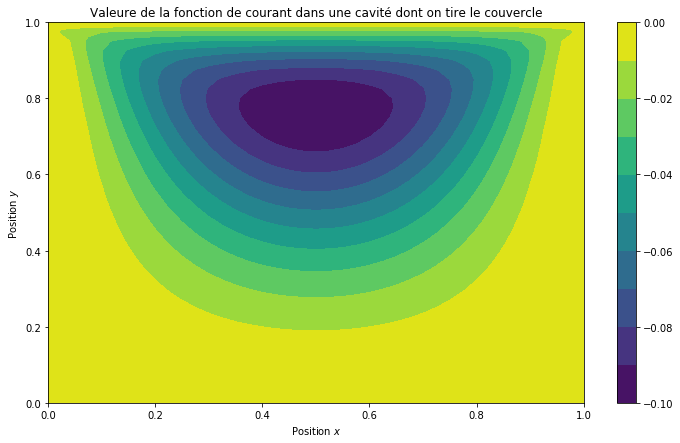

In [5]:
p0 = np.zeros((nx, ny))
b = np.zeros((nx, ny))
# We compute b and extend it to nx x ny for simplicity in the biharm_2d function (so his size is nx x ny)
b[-4, 2:-2] = +dy/2
b[-3, 2:-2] = -2*dy
data = biharm_2d_conjugate_gradient(p0, b, dx, dy, rtol=l1_target)

x = np.linspace(0, l, nx)
y = np.linspace(0, h, ny)
X,Y = np.meshgrid(x, y)
Z = data[0]

plt.figure(figsize=(12,7))
plt.title("Valeure de la fonction de courant dans une cavité dont on tire le couvercle")
plt.xlabel("Position $x$")
plt.ylabel("Position $y$")
plt.contourf(X, Y, Z, 11)
plt.colorbar()

On s'assure de la convergence de la méthode. En particulier, le nombre d'itération doit être inférieur à `maxiter`.

In [6]:
print(len(data[2])) # Number of step.

1413


On s'intéresse à la valeur de la fonction de courant à certains endroits particuliers (comme proposé dans le MOOC)

In [7]:
print('La fonction de courant à la position (x,y)=(0.6,0.2) est ' + repr(Z[8,24]))
print('La fonction de courant à la position (x,y)=(0.6,0.4) est ' + repr(Z[16,24]))
print('La fonction de courant à la position (x,y)=(0.6,0.6) est ' + repr(Z[24,24]))
print('La fonction de courant à la position (x,y)=(0.6,0.8) est ' + repr(Z[36,24]))

La fonction de courant à la position (x,y)=(0.6,0.2) est -0.010031328044445209
La fonction de courant à la position (x,y)=(0.6,0.4) est -0.03613386864489836
La fonction de courant à la position (x,y)=(0.6,0.6) est -0.07376579571198699
La fonction de courant à la position (x,y)=(0.6,0.8) est -0.07084946032565259


# Références

* MOOC : [Practical Numerical Methods with Python](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about)
* Coefficients des différences finies https://en.wikipedia.org/wiki/Finite_difference_coefficient